In [146]:
!pip install aif360

In [156]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score, r2_score
from aif360.sklearn.metrics import equal_opportunity_difference
from sklearn.metrics import mean_squared_error
from math import sqrt

imputer = IterativeImputer()
encoder = LabelEncoder()

In [157]:
def stat_parity(preds, sens):

    tpr = np.mean(preds[(sens == 1)])
    tpr_non = np.mean(preds[(sens == 0)])

    return abs(tpr - tpr_non)

def eq_oppo(preds, sens, labels):
    tpr = np.mean(preds[(labels == 1) & (sens == 1)])
    tpr_non = np.mean(preds[(labels == 1) & (sens == 0)])

    return abs(tpr - tpr_non)


In [158]:
credit_df = pd.read_csv("Credit.csv")
credit_df.drop(columns=['Unnamed: 0'], inplace=True)
credit_df.drop(columns=['Gender'], inplace=True)

credit_df.head(5)

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,No,No,Asian,580
3,148.924,9504,681,3,36,11,No,No,Asian,964
4,55.882,4897,357,2,68,16,No,Yes,Caucasian,331


In [159]:
#credit_df.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
#plt.gca().spines[['top', 'right',]].set_visible(False)

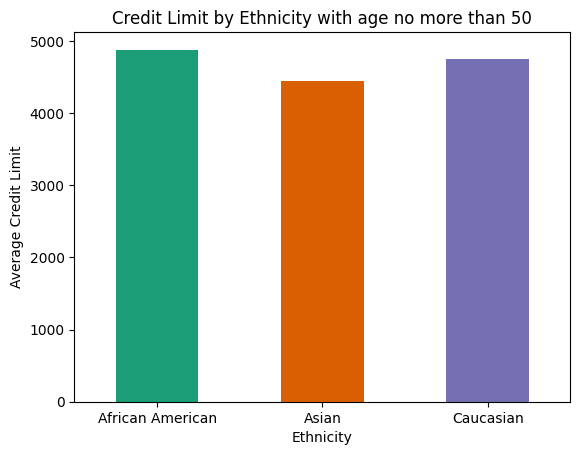

In [160]:
credit_df_young = credit_df[(credit_df['Age'] >= 0) & (credit_df['Age'] <= 50)]
ethnicity_balance_mean = credit_df_young.groupby('Ethnicity')['Limit'].mean()
ax = ethnicity_balance_mean.plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))

plt.xlabel('Ethnicity', rotation=0)
plt.ylabel('Average Credit Limit')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
_ = plt.title('Credit Limit by Ethnicity with age no more than 50')

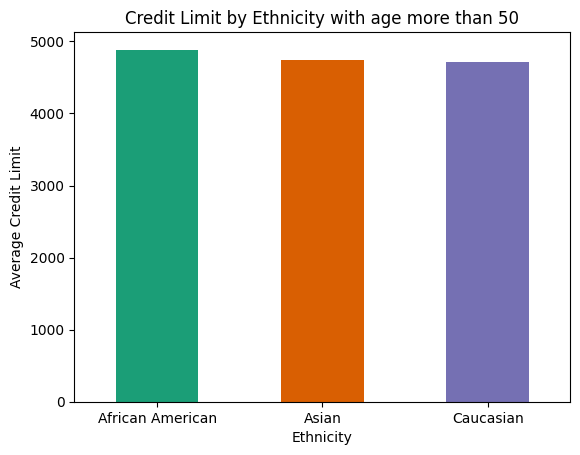

In [161]:
credit_df_old = credit_df[(credit_df['Age'] > 50)]
ethnicity_balance_mean = credit_df_old.groupby('Ethnicity')['Limit'].mean()
ax = ethnicity_balance_mean.plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))

plt.xlabel('Ethnicity', rotation=0)
plt.ylabel('Average Credit Limit')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
_ = plt.title('Credit Limit by Ethnicity with age more than 50')

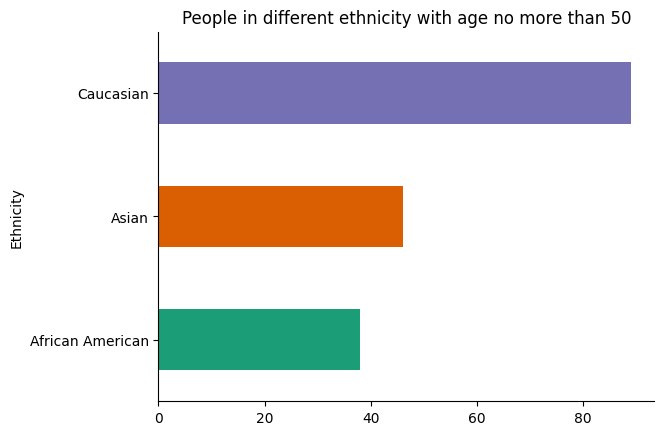

In [162]:
credit_df_young.groupby('Ethnicity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
_ = plt.title('People in different ethnicity with age no more than 50')


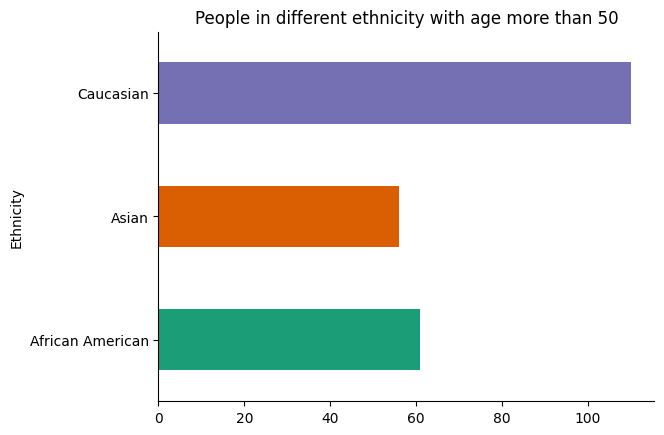

In [163]:
credit_df_old.groupby('Ethnicity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
_ = plt.title('People in different ethnicity with age more than 50')

In [164]:
def process_split(df):
  df['Student'] = encoder.fit_transform(df['Student'].astype(str))
  df['Married'] = encoder.fit_transform(df['Married'].astype(str))
  df['Ethnicity'] = encoder.fit_transform(df['Ethnicity'].astype(str))
  X_credit = df.drop(columns=['Limit'])
  y_credit = df['Limit']
  X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(X_credit, y_credit, test_size=0.3, random_state=42)
  return X_credit_train, X_credit_test, y_credit_train, y_credit_test

In [165]:
X_credit_train_young, X_credit_test_young, y_credit_train_young, y_credit_test_young = process_split(credit_df_young)

<ipython-input-164-0ba21e8169df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Student'] = encoder.fit_transform(df['Student'].astype(str))
<ipython-input-164-0ba21e8169df>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Married'] = encoder.fit_transform(df['Married'].astype(str))
<ipython-input-164-0ba21e8169df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [166]:
X_credit_train_young.head(5)

,Income,Rating,Cards,Age,Education,Student,Married,Ethnicity,Balance
153,92.112,344,3,32,17,0,0,2,0
75,33.017,224,2,28,16,0,1,0,29
296,65.896,370,1,49,17,0,1,2,293
44,31.861,469,3,25,16,0,1,2,1120
321,25.078,236,2,27,15,0,1,2,81


In [167]:
df_test_senses_credit_young = X_credit_test_young['Ethnicity']
test_senses_credit_young = df_test_senses_credit_young.values

#fit linear regression
lg_clf = LinearRegression()
lg_clf.fit(X_credit_train_young,y_credit_train_young)
y_pred = lg_clf.predict(X_credit_test_young)

print("R squared with Ethnicity: ", r2_score(y_credit_test_young,y_pred))
print("RMSE with Ethnicity: ", sqrt(mean_squared_error(y_credit_test_young, y_pred)))

data_E = {
    'Category': ['Young with Ethnicity'],
    'RMSE': [sqrt(mean_squared_error(y_credit_test_young, y_pred))],
    'R-squared': [ r2_score(y_credit_test_young,y_pred)]
}

#fit linear regression model again without the column Ethnicity
X_credit_no_ethnicity = X_credit_train_young.loc[:, X_credit_train_young.columns != 'Ethnicity']
X_credit_test_noethnicity = X_credit_test_young.loc[:, X_credit_test_young.columns != 'Ethnicity']

lg_clf = LinearRegression()
lg_clf.fit(X_credit_no_ethnicity,y_credit_train_young)
y_pred = lg_clf.predict(X_credit_test_noethnicity)
print("R Squared without Ethnicity: ", r2_score(y_credit_test_young,y_pred))
print("RMSE without Ethnicity: ", sqrt(mean_squared_error(y_credit_test_young, y_pred)))


data_no_E = {
    'Category': ['Young without Ethnicity'],
    'RMSE': [sqrt(mean_squared_error(y_credit_test_young, y_pred))],
    'R-squared': [ r2_score(y_credit_test_young,y_pred)]
}


R squared with Ethnicity:  0.9950560157830786
RMSE with Ethnicity:  169.44272768317728
R Squared without Ethnicity:  0.9952147047738074
RMSE without Ethnicity:  166.70121473634555


In [168]:
df_with_eth = pd.DataFrame(data_E)
df_without_eth = pd.DataFrame(data_no_E)
df_with_eth_young = pd.concat([df_with_eth, df_without_eth], ignore_index=True)
df_with_eth_young

,Category,RMSE,R-squared
0,Young with Ethnicity,169.442728,0.995056
1,Young without Ethnicity,166.701215,0.995215


In [169]:
X_credit_train_old, X_credit_test_old, y_credit_train_old, y_credit_test_old = process_split(credit_df_old)
df_test_senses_credit_old = X_credit_test_old['Ethnicity']
test_senses_credit_old = df_test_senses_credit_old.values

#fit linear regression
lg_clf = LinearRegression()
lg_clf.fit(X_credit_train_old,y_credit_train_old)
y_pred = lg_clf.predict(X_credit_test_old)

print("R squared with Ethnicity: ", r2_score(y_credit_test_old,y_pred))
print("RMSE with Ethnicity: ", sqrt(mean_squared_error(y_credit_test_old, y_pred)))

data_E = {
    'Category': ['Old with Ethnicity'],
    'RMSE': [sqrt(mean_squared_error(y_credit_test_old, y_pred))],
    'R-squared': [ r2_score(y_credit_test_old,y_pred)]
}

#fit linear regression model again without the column Ethnicity
X_credit_no_ethnicity = X_credit_train_old.loc[:, X_credit_train_old.columns != 'Ethnicity']
X_credit_test_noethnicity = X_credit_test_old.loc[:, X_credit_test_old.columns != 'Ethnicity']

lg_clf = LinearRegression()
lg_clf.fit(X_credit_no_ethnicity,y_credit_train_old)
y_pred = lg_clf.predict(X_credit_test_noethnicity)
print("R Squared without Ethnicity: ", r2_score(y_credit_test_old,y_pred))
print("RMSE without Ethnicity: ", sqrt(mean_squared_error(y_credit_test_old, y_pred)))


data_no_E = {
    'Category': ['Old without Ethnicity'],
    'RMSE': [sqrt(mean_squared_error(y_credit_test_old, y_pred))],
    'R-squared': [ r2_score(y_credit_test_old,y_pred)]
}

df_with_eth = pd.DataFrame(data_E)
df_without_eth = pd.DataFrame(data_no_E)
df_with_eth_old = pd.concat([df_with_eth, df_without_eth], ignore_index=True)
df_with_eth_old


R squared with Ethnicity:  0.9955455723409252
RMSE with Ethnicity:  160.2225499438406
R Squared without Ethnicity:  0.9959124988515177
RMSE without Ethnicity:  153.48170956264278


<ipython-input-164-0ba21e8169df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Student'] = encoder.fit_transform(df['Student'].astype(str))
<ipython-input-164-0ba21e8169df>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Married'] = encoder.fit_transform(df['Married'].astype(str))
<ipython-input-164-0ba21e8169df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,Category,RMSE,R-squared
0,Old with Ethnicity,160.22255,0.995546
1,Old without Ethnicity,153.48171,0.995912


Change Credit Card Limit to categorical data, which Credit Card Limit no more than 4000 is 0, Credit Card Limit more than 3500 is 1

Therefore, statisitcal parity and equalied opportunity is available to use to varify the bias of the model.

In [170]:
credit_df_young_cat = credit_df_young.copy()
credit_df_young_cat['Limit'] = pd.cut(credit_df_young_cat['Limit'], bins=[-float('inf'), 3500, float('inf')], labels=[0, 1])
X_credit_train_young_cat, X_credit_test_young_cat, y_credit_train_young_cat, y_credit_test_young_cat = train_test_split(credit_df_young_cat.drop(columns=['Limit']), credit_df_young_cat['Limit'], test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf.fit(X_credit_train_young_cat,y_credit_train_young_cat)
y_pred = rf_clf.predict(X_credit_test_young_cat)

Tac1 = accuracy_score(y_credit_test_young_cat,y_pred)

f1 = cross_val_score(rf_clf,X_credit_train_young_cat,y_credit_train_young_cat,cv=5,scoring='f1_macro').mean()
acc1 = cross_val_score(rf_clf,X_credit_train_young_cat,y_credit_train_young_cat,cv=5,scoring='accuracy').mean()

stat_p1 = stat_parity(y_pred, X_credit_test_young_cat['Ethnicity'])
eq_op1 = equal_opportunity_difference(y_credit_test_young_cat, y_pred)

data_E = {
    'Category': ['Young with Ethnicity categorical'],
    'Train Accuracy': [Tac1],
    'Validation Mean F1 Score': [f1],
    'Validation Mean Accuracy': [acc1],
    'Statistical Parity': [stat_p1],
    'Equalized Opportunity': [eq_op1]
}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [171]:
X_credit_train_young_cat_noE = X_credit_train_young_cat.drop(columns=['Ethnicity'])
X_credit_test_young_cat_noE = X_credit_test_young_cat.drop(columns=['Ethnicity'])


rf_clf_noE = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf_noE.fit(X_credit_train_young_cat_noE,y_credit_train_young_cat)
y_pred_noE = rf_clf_noE.predict(X_credit_test_young_cat_noE)

stat_p2 = stat_parity(y_pred_noE, X_credit_test_young_cat['Ethnicity'])
eq_op2 = equal_opportunity_difference(y_credit_test_young_cat, y_pred_noE)


data_no_E = {
    'Category': ['Young without Ethnicity categorical'],
    'Train Accuracy': [accuracy_score(y_credit_test_young_cat,y_pred_noE)],
    'Validation Mean F1 Score': [cross_val_score(rf_clf_noE,X_credit_train_young_cat_noE,y_credit_train_young_cat,cv=5,scoring='f1_macro').mean()],
    'Validation Mean Accuracy': [ cross_val_score(rf_clf_noE,X_credit_train_young_cat_noE,y_credit_train_young_cat,cv=5,scoring='accuracy').mean()],
    'Statistical Parity': [stat_p2],
    'Equalized Opportunity': [eq_op2]
}
df_with_eth_c = pd.DataFrame(data_E)
df_without_eth_c = pd.DataFrame(data_no_E)
df_with_eth_young_c = pd.concat([df_with_eth_c, df_without_eth_c], ignore_index=True)
df_with_eth_young_c

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Category,Train Accuracy,Validation Mean F1 Score,Validation Mean Accuracy,Statistical Parity,Equalized Opportunity
0,Young with Ethnicity categorical,0.980769,0.941769,0.950667,0.264706,1.0
1,Young without Ethnicity categorical,0.980769,0.941769,0.950667,0.264706,1.0


In [172]:
credit_df_old_cat = credit_df_old.copy()
credit_df_old_cat['Limit'] = pd.cut(credit_df_old_cat['Limit'], bins=[-float('inf'), 3500, float('inf')], labels=[0, 1])
X_credit_train_old_cat, X_credit_test_old_cat, y_credit_train_old_cat, y_credit_test_old_cat = train_test_split(credit_df_old_cat.drop(columns=['Limit']), credit_df_old_cat['Limit'], test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf.fit(X_credit_train_old_cat,y_credit_train_old_cat)
y_pred = rf_clf.predict(X_credit_test_old_cat)

ta1 = accuracy_score(y_credit_test_old_cat,y_pred)

vf1 = cross_val_score(rf_clf,X_credit_train_old_cat,y_credit_train_old_cat,cv=5,scoring='f1_macro').mean()
vac1 = cross_val_score(rf_clf,X_credit_train_old_cat,y_credit_train_old_cat,cv=5,scoring='accuracy').mean()

stat_p1 = stat_parity(y_pred, X_credit_test_old_cat['Ethnicity'])
eq_op1 = equal_opportunity_difference(y_credit_test_old_cat, y_pred)

data_E = {
    'Category': ['Old with Ethnicity categorical'],
    'Train Accuracy': [ta1],
    'Validation Mean F1 Score': [vf1],
    'Validation Mean Accuracy': [vac1],
    'Statistical Parity': [stat_p1],
    'Equalized Opportunity': [eq_op1]
}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [173]:
X_credit_train_old_cat_noE = X_credit_train_old_cat.drop(columns=['Ethnicity'])
X_credit_test_old_cat_noE = X_credit_test_old_cat.drop(columns=['Ethnicity'])


rf_clf_noE = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf_noE.fit(X_credit_train_old_cat_noE,y_credit_train_old_cat)
y_pred_noE = rf_clf_noE.predict(X_credit_test_old_cat_noE)

stat_p2 = stat_parity(y_pred_noE, X_credit_test_old_cat['Ethnicity'])
eq_op2 = equal_opportunity_difference(y_credit_test_old_cat, y_pred_noE)


data_no_E = {
    'Category': ['Old without Ethnicity categorical'],
    'Train Accuracy': [accuracy_score(y_credit_test_old_cat,y_pred_noE)],
    'Validation Mean F1 Score': [cross_val_score(rf_clf_noE,X_credit_train_old_cat_noE,y_credit_train_old_cat,cv=5,scoring='f1_macro').mean()],
    'Validation Mean Accuracy': [ cross_val_score(rf_clf_noE,X_credit_train_old_cat_noE,y_credit_train_old_cat,cv=5,scoring='accuracy').mean()],
    'Statistical Parity': [stat_p2],
    'Equalized Opportunity': [eq_op2]
}
df_with_eth_c = pd.DataFrame(data_E)
df_without_eth_c = pd.DataFrame(data_no_E)
df_with_eth_old_c = pd.concat([df_with_eth_c, df_without_eth_c], ignore_index=True)
df_with_eth_old_c

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Category,Train Accuracy,Validation Mean F1 Score,Validation Mean Accuracy,Statistical Parity,Equalized Opportunity
0,Old with Ethnicity categorical,1.000000,0.973694,0.98125,0.061905,1.0
1,Old without Ethnicity categorical,0.985507,0.966782,0.98125,0.061905,1.0


In [174]:
loan_df = pd.read_csv("train.csv")
loan_df.drop(columns=['Loan_ID'], inplace=True)
loan_df.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


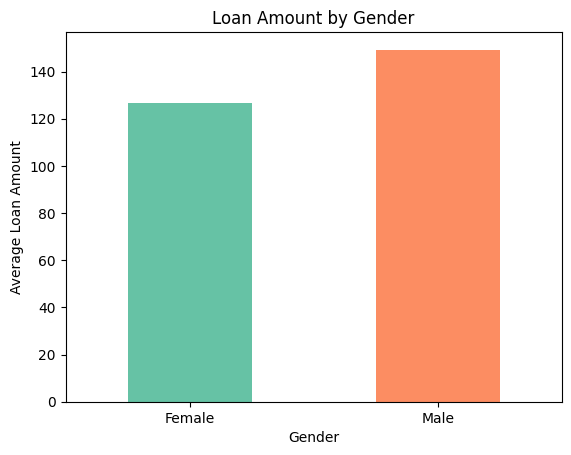

In [175]:
gender_amount_mean = loan_df.groupby('Gender')['LoanAmount'].mean()
ax = gender_amount_mean.plot(kind='bar', color=sns.palettes.mpl_palette('Set2'))
plt.xlabel('Gender')
plt.ylabel('Average Loan Amount')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
_ = plt.title('Loan Amount by Gender')

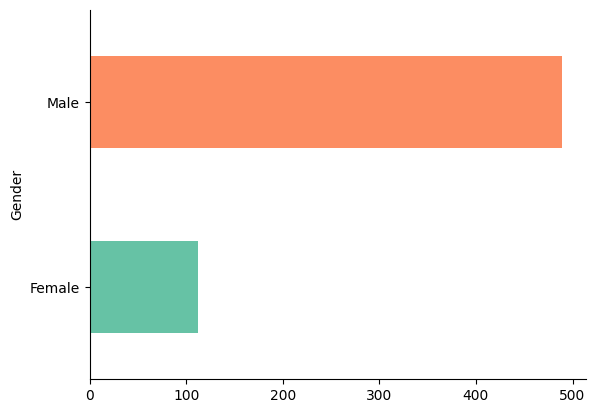

In [176]:
loan_df.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Set2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [177]:
loan_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [178]:
loan_df['Gender'] = encoder.fit_transform(loan_df['Gender'].astype(str))
loan_df['Married'] = encoder.fit_transform(loan_df['Married'].astype(str))
loan_df['Education'] = encoder.fit_transform(loan_df['Education'].astype(str))
loan_df['Self_Employed'] = encoder.fit_transform(loan_df['Self_Employed'].astype(str))
loan_df['Property_Area'] = encoder.fit_transform(loan_df['Property_Area'].astype(str))
loan_df['Loan_Status'] = encoder.fit_transform(loan_df['Loan_Status'].astype(str))


columns_to_impute = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
imputer.fit(loan_df[columns_to_impute])
df_imputed = pd.DataFrame(imputer.transform(loan_df[columns_to_impute]), columns=columns_to_impute)

#gender_map = {0: 'Female', 1: 'Male'}
#loan_df['Gender'] = loan_df['Gender'].map(gender_map)

#married_map = {0: 'No', 1: 'Yes'}
#loan_df['Married'] = loan_df['Married'].map(married_map)

#Education_map = {0: 'Graduate', 1: 'Not Graduate'}
#loan_df['Education'] = loan_df['Education'].map(Education_map)

#Self_Employed_map = {0: 'No', 1: 'Yes'}
#loan_df['Self_Employed'] = loan_df['Self_Employed'].map(Self_Employed_map)

#Property_Area_map = {0: 'Rural', 1: 'Semiurban', 2: 'Urban'}
#loan_df['Property_Area'] = loan_df['Property_Area'].map(Property_Area_map)

#Loan_Status_map = {0: 'No', 1: 'Yes'}
#loan_df['Loan_Status'] = loan_df['Loan_Status'].map(Loan_Status_map)

loan_df['ApplicantIncome'].fillna(loan_df['ApplicantIncome'].mean(), inplace=True)
loan_df['CoapplicantIncome'].fillna(loan_df['CoapplicantIncome'].mean(), inplace=True)
loan_df['LoanAmount'].fillna(loan_df['LoanAmount'].mean(), inplace=True)
loan_df['Loan_Amount_Term'].fillna(loan_df['Loan_Amount_Term'].mean(), inplace=True)

loan_df.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1


In [179]:
loan_df.loc[loan_df['Dependents'] == '3+', 'Dependents'] = 3
loan_df['Dependents'].fillna(0, inplace=True)
loan_df['Credit_History'].fillna(0, inplace=True)
loan_df.head(5)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1


In [180]:
nan_in_column = loan_df['Property_Area'].isna().all()
if nan_in_column:
    print("There are NaN values in the column.")
else:
    print("There are no NaN values in the column.")


There are no NaN values in the column.


In [181]:
#train test split
y_loan = loan_df['Loan_Status']
X_loan = loan_df.drop(columns=['Loan_Status'])
X_loan_train, X_loan_test, y_loan_train, y_loan_test = train_test_split(X_loan, y_loan, test_size=0.3, random_state=42)

Random Forest Model

In [182]:
df_test_senses_loan = X_loan_test['Gender']
test_senses_loan = df_test_senses_loan.values

In [183]:
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf.fit(X_loan_train,y_loan_train)
y_pred = rf_clf.predict(X_loan_test)
print("Train Accuracy ", accuracy_score(y_loan_test,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(rf_clf,X_loan_train,y_loan_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(rf_clf,X_loan_train,y_loan_train,cv=5,scoring='accuracy').mean())

stat_p1 = stat_parity(y_pred, test_senses_loan)
eq_op1 = equal_opportunity_difference(y_loan_test, y_pred)
print("Statistical Parity for loan data with gender label:", stat_p1)
print("Equalized Opportunity for loan data with gender label:", eq_op1)


Train Accuracy  0.7243243243243244
Validation Mean F1 Score:  0.5179386003442871
Validation Mean Accuracy:  0.7203283173734609
Statistical Parity for loan data with gender label: 0.08640552995391715
Equalized Opportunity for loan data with gender label: 0.9166666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [184]:
#drop Gender column and fit the model again
X_loan_no_gender = X_loan_train.loc[:, X_loan_train.columns != 'Gender']
X_loan_test_nogender = X_loan_test.loc[:, X_loan_test.columns != 'Gender']

rf_clf2 = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf2.fit(X_loan_no_gender,y_loan_train)
y_pred = rf_clf2.predict(X_loan_test_nogender)
print("Train Accuracy ", accuracy_score(y_loan_test,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(rf_clf2,X_loan_no_gender,y_loan_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(rf_clf2,X_loan_no_gender,y_loan_train,cv=5,scoring='accuracy').mean())
stat_p2 = stat_parity(y_pred, test_senses_loan)
eq_op2 = equal_opportunity_difference(y_loan_test, y_pred)
print("Statistical Parity for loan data without gender label:", stat_p2)
print("Equalized Opportunity for loan data without gender label:", eq_op2)

Train Accuracy  0.6972972972972973
Validation Mean F1 Score:  0.57635670763231
Validation Mean Accuracy:  0.7296580027359781
Statistical Parity for loan data without gender label: 0.04769585253456221
Equalized Opportunity for loan data without gender label: 0.925


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM

In [185]:
from sklearn.svm import SVC

svm_model = SVC(kernel = 'sigmoid')
svm_model.fit(X_loan_train,y_loan_train)
svm_y_pred = svm_model.predict(X_loan_test)
print("Train Accuracy ", accuracy_score(y_loan_test,svm_y_pred))

print("Validation Mean F1 Score: ",cross_val_score(svm_model,X_loan_train,y_loan_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(svm_model,X_loan_train,y_loan_train,cv=5,scoring='accuracy').mean())

svm_stat_p1 = stat_parity(svm_y_pred, test_senses_loan)
print("Statistical Parity for loan data with gender label:", svm_stat_p1)

svm_eq_op1 = equal_opportunity_difference(y_loan_test, svm_y_pred)
print("Equalized Opportunity for loan data without gender label:", svm_eq_op1)


Train Accuracy  0.6162162162162163
Validation Mean F1 Score:  0.46524562102829037
Validation Mean Accuracy:  0.6062106703146374
Statistical Parity for loan data with gender label: 0.04009216589861753
Equalized Opportunity for loan data without gender label: 0.8333333333333334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [186]:
svm_model2 = SVC(kernel = 'sigmoid')
svm_model2.fit(X_loan_no_gender,y_loan_train)
svm_y_pred2 = svm_model2.predict(X_loan_test_nogender)
print("Train Accuracy ", accuracy_score(y_loan_test,svm_y_pred2))

print("Validation Mean F1 Score: ",cross_val_score(svm_model2,X_loan_no_gender,y_loan_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(svm_model2,X_loan_no_gender,y_loan_train,cv=5,scoring='accuracy').mean())
svm_stat_p2 = stat_parity(svm_y_pred2, test_senses_loan)
print("Statistical Parity for loan data without gender label:", svm_stat_p2)

svm_eq_op2 = equal_opportunity_difference(y_loan_test, svm_y_pred2)
print("Equalized Opportunity for loan data without gender label:", svm_eq_op2)

Train Accuracy  0.6162162162162163
Validation Mean F1 Score:  0.46524562102829037
Validation Mean Accuracy:  0.6062106703146374
Statistical Parity for loan data without gender label: 0.04009216589861753
Equalized Opportunity for loan data without gender label: 0.8333333333333334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [187]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(X_loan_train,y_loan_train)
logistic_y_pred = svm_model.predict(X_loan_test)
print("Train Accuracy ", accuracy_score(y_loan_test,logistic_y_pred))
print("Validation Mean F1 Score: ",cross_val_score(svm_model,X_loan_train,y_loan_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(svm_model,X_loan_train,y_loan_train,cv=5,scoring='accuracy').mean())

logistic_stat_p1 = stat_parity(logistic_y_pred, test_senses_loan)
print("Statistical Parity for loan data with gender label:", logistic_stat_p1)

logistic_eq_op1 = equal_opportunity_difference(y_loan_test, logistic_y_pred)
print("Equalized Opportunity for loan data without gender label:", logistic_eq_op1)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy  0.6162162162162163
Validation Mean F1 Score:  0.46524562102829037
Validation Mean Accuracy:  0.6062106703146374
Statistical Parity for loan data with gender label: 0.04009216589861753
Equalized Opportunity for loan data without gender label: 0.8333333333333334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [188]:
logistic_model2 = LogisticRegression()
logistic_model2.fit(X_loan_no_gender,y_loan_train)
logistic_y_pred2 = logistic_model2.predict(X_loan_test_nogender)
print("Train Accuracy ", accuracy_score(y_loan_test,logistic_y_pred2))

print("Validation Mean F1 Score: ",cross_val_score(logistic_model2,X_loan_no_gender,y_loan_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(logistic_model2,X_loan_no_gender,y_loan_train,cv=5,scoring='accuracy').mean())
logistic_stat_p2 = stat_parity(logistic_y_pred2, test_senses_loan)
print("Statistical Parity for loan data without gender label:", logistic_stat_p2)

logistic_eq_op2 = equal_opportunity_difference(y_loan_test, logistic_y_pred2)
print("Equalized Opportunity for loan data without gender label:", logistic_eq_op2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy  0.7567567567567568
Validation Mean F1 Score:  0.6597934006852698
Validation Mean Accuracy:  0.7505608755129959
Statistical Parity for loan data without gender label: 0.01774193548387093
Equalized Opportunity for loan data without gender label: 0.9


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
